# Demo of Predictive State Smoothing (PRESS)

PRESS is a kernel smoothing technique for any type of predictive learning problem (classification, regression, ...).

This notebook shows examples of how to use the main functionality for a regression and classification problem.  Core PRESS functionality and layers, though, can be used for any learning problem with non-standard activation functions.

See also


* Goerg (2018) *[Classification using Predictive State Smoothing (PRESS): A scalable kernel classifier for high-dimensional features with variable selection](https://research.google/pubs/pub46767/)*.

* Goerg (2017) *[Predictive State Smoothing (PRESS): Scalable non-parametric regression for high-dimensional data with variable selection](https://research.google/pubs/pub46141/).*


In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import importlib
import os
import sys
import pathlib
import tensorflow as tf

from os.path import dirname
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import logging
import datetime
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [22]:
from pypress.keras import layers
from pypress.keras import initializers
from pypress.keras import regularizers
from pypress import utils

importlib.reload(layers)

<module 'pypress.keras.layers' from '/home/georg/Projects/pypress/pypress/keras/layers.py'>

# Utility functions and setup

In [23]:
# misc helper functions
from typing import Tuple, Any
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import RobustScaler


def _get_loss_activation_metrics(y: pd.Series) -> Tuple[Any, Any, Any]:

    if len(np.unique(y)) == 2:
        act = "sigmoid"
        loss_fn = "binary_crossentropy"
        metrics = [tf.keras.metrics.AUC(curve="PR", name="aupr"), tf.keras.metrics.AUC(curve="ROC", name="auc_roc")]
    else:
        act = "linear"
        loss_fn = "mse"
        metrics = [tf.keras.metrics.mean_squared_error]
        
        if (y >= 0.).all():
            act = "softplus"
            loss_fn = "mse"

    return (loss_fn, act, metrics)


def _get_recommended_callbacks():
    logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logdir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
    return [tf.keras.callbacks.EarlyStopping(patience=10),
                             tensorboard_callback], logdir


def _scale_df(X, scaler = None):
    
    if scaler is None:
        scaler = RobustScaler()
        scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index), scaler


def _train_test_scale(X, y):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    X_train_s, scaler = _scale_df(X_train, None)
    X_test_s, scaler = _scale_df(X_test, scaler)
    
    return (X_train, y_train, X_test, y_test), scaler


# Regression


In [24]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)

In [25]:
X, y = housing["data"], housing["target"]
X.shape, y.shape

((20640, 8), (20640,))

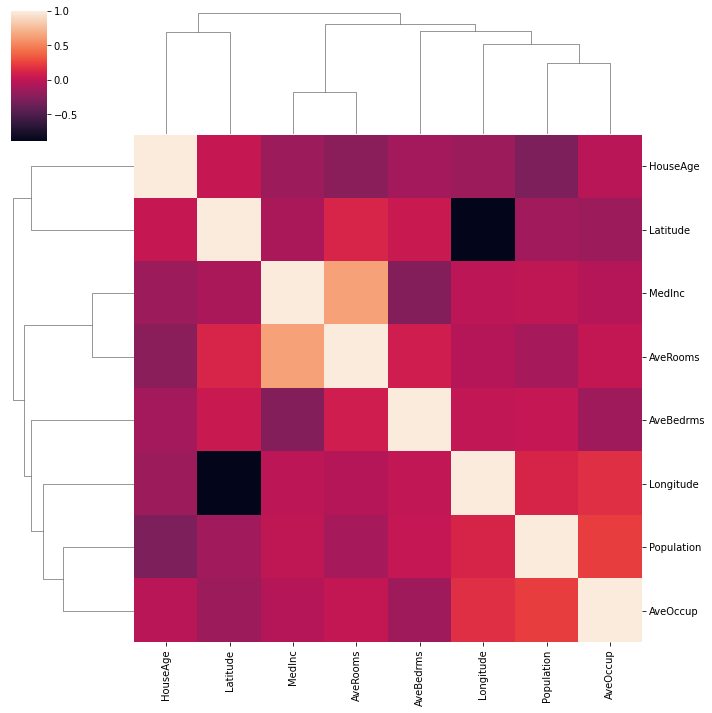

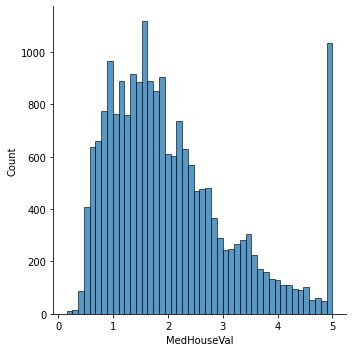

In [26]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [27]:
X = X.loc[y < 5]
y = y.loc[y < 5]

X.shape, y.shape

((19648, 8), (19648,))

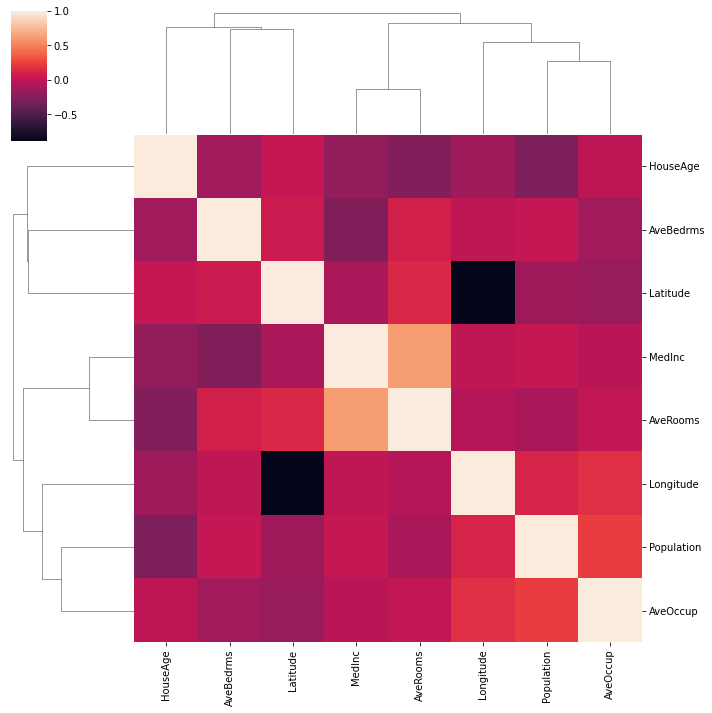

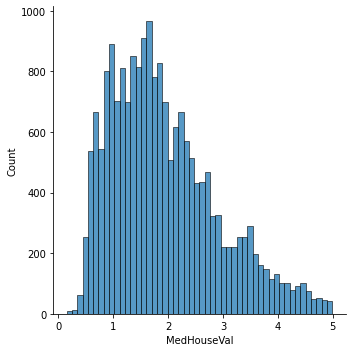

In [28]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [29]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape

(15718, 8)

In [116]:
loss_fn, act, metrics = _get_loss_activation_metrics(y_ts)
print(act, loss_fn)

feat_input = tf.keras.layers.Input(shape=(X_tr.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(30, "relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(10, "tanh", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
#feat_eng_layer.add(tf.keras.layers.Dense(100, "tanh"))
#feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
#feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
eps_mapping = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(l1=0.01),
                                            kernel_regularizer=tf.keras.regularizers.l2(0.001))
pred_states = eps_mapping(hidden)
state_mean_layer = layers.PredictiveStateMeans(units=1, activation=act)
pred = state_mean_layer(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005),
            metrics=metrics)
mod.summary()

softplus mse
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 8)]               0         
                                                                 
 sequential_15 (Sequential)  (None, 10)                740       
                                                                 
 predictive_state_simplex_13  (None, 5)                55        
  (PredictiveStateSimplex)                                       
                                                                 
 predictive_state_means_13 (  (None, 1)                5         
 PredictiveStateMeans)                                           
                                                                 
Total params: 800
Trainable params: 720
Non-trainable params: 80
_________________________________________________________________


In [117]:
eps_mapping.trainable_weights

[<tf.Variable 'predictive_state_simplex_13/kernel:0' shape=(10, 5) dtype=float32, numpy=
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'predictive_state_simplex_13/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>]

In [118]:
state_mean_layer.trainable_variables

[<tf.Variable 'predictive_state_means_13/state_conditional_mean_logits:0' shape=(5, 1) dtype=float32, numpy=
 array([[-0.935133  ],
        [ 0.07441783],
        [-0.9573536 ],
        [ 0.8181517 ],
        [ 0.14265513]], dtype=float32)>]

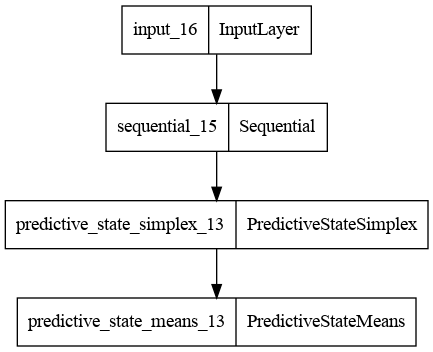

In [119]:
tf.keras.utils.plot_model(mod)

In [120]:
history = mod.fit(X_tr, y_tr, epochs=10, batch_size=32,
                  validation_data=(X_ts, y_ts),
                  callbacks=[],#_get_recommended_callbacks()
                 )

Epoch 1/10
492/492 [==============================] - 2s 2ms/step - loss: 1.1708 - mean_squared_error: 1.1577 - val_loss: 0.9438 - val_mean_squared_error: 0.9330
Epoch 2/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9571 - mean_squared_error: 0.9486 - val_loss: 0.9289 - val_mean_squared_error: 0.9226
Epoch 3/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9538 - mean_squared_error: 0.9484 - val_loss: 0.9282 - val_mean_squared_error: 0.9236
Epoch 4/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9520 - mean_squared_error: 0.9478 - val_loss: 0.9268 - val_mean_squared_error: 0.9235
Epoch 5/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9510 - mean_squared_error: 0.9480 - val_loss: 0.9283 - val_mean_squared_error: 0.9255
Epoch 6/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9503 - mean_squared_error: 0.9477 - val_loss: 0.9262 - val_mean_squared_error: 0.9239
Epoch 7/10
492/492 [========

In [121]:
mod.layers[-1].state_conditional_means.numpy().ravel()

array([0.51178145, 1.1078001 , 0.50305456, 1.9712632 , 1.6313059 ],
      dtype=float32)

<AxesSubplot:>

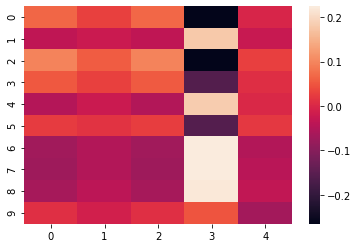

In [122]:
sns.heatmap(eps_mapping.trainable_weights[0].numpy())

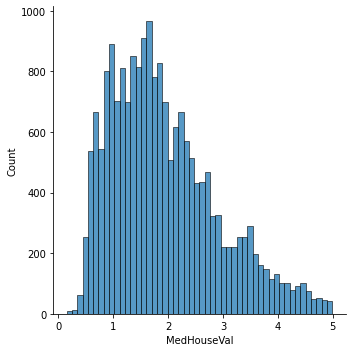

In [123]:
sns.displot(y)

/home/georg/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


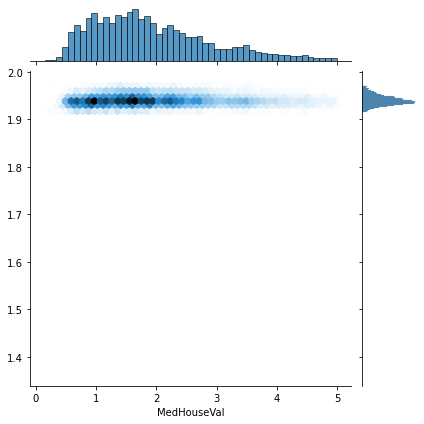

In [124]:
y_pred = mod.predict(X)

sns.jointplot(y, y_pred.ravel(), kind="hex")

(3930, 8)


<AxesSubplot:>

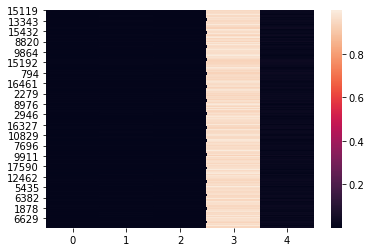

In [125]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = state_mapping(X_ts.values).numpy()
pred_emb = pd.DataFrame(pred_emb, index=X_ts.index)
sns.heatmap(pred_emb)

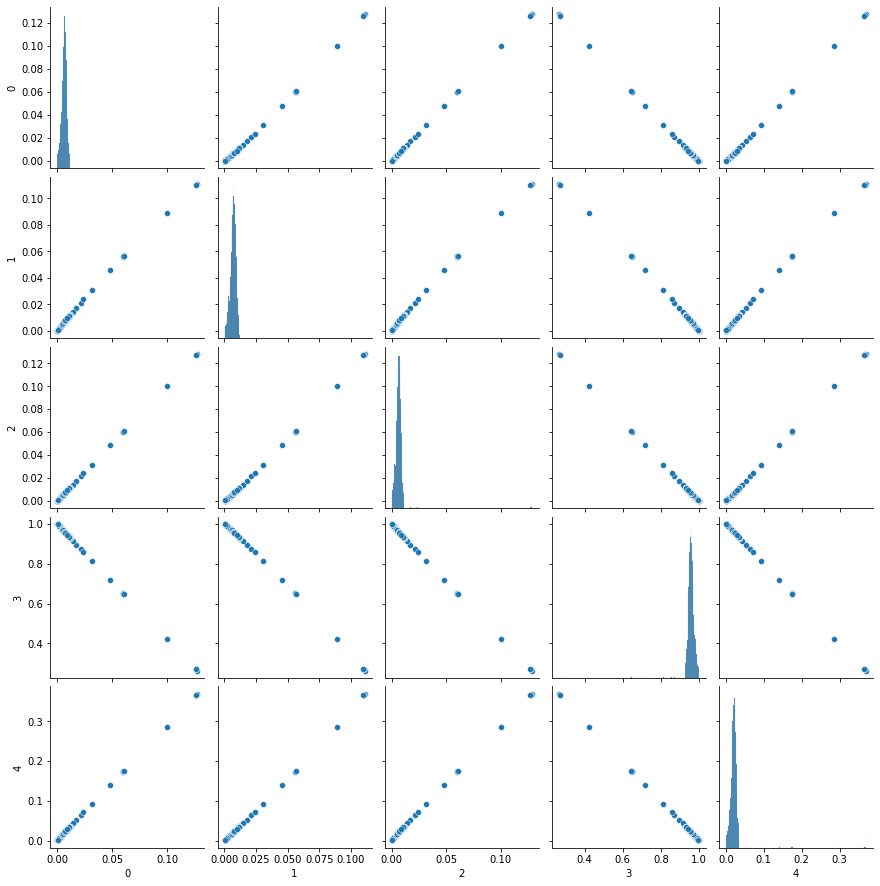

In [126]:
sns.pairplot(pred_emb)

In [ ]:
pred_emb.shape

In [ ]:
utils.col_normalize(pred_emb).sum(axis=0)

In [ ]:
X_ts.head()

In [ ]:
utils.size_state(pred_emb)

In [ ]:
utils.agg_data_by_state(pred_emb, X_ts).round(2)

# Classification

In [127]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

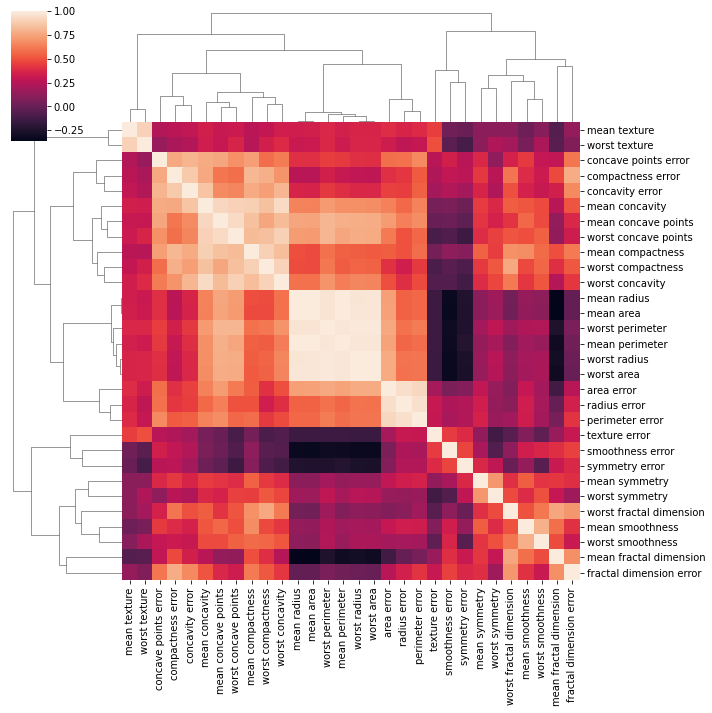

In [128]:
sns.clustermap(X.corr("spearman"))

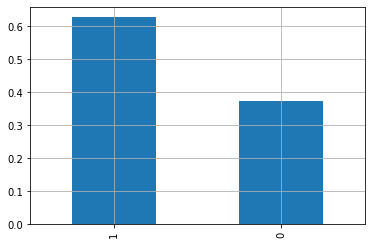

In [133]:
y.value_counts(normalize=True).plot.bar()
plt.grid()

In [134]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape, X_ts.shape

((455, 30), (114, 30))

In [157]:
loss_fn, act, metrics = _get_loss_activation_metrics(y)

feat_input = tf.keras.layers.Input(shape=(X.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(50, "selu"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "tanh"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
pred_states = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(10.))(hidden)
pred = layers.PredictiveStateMeans(units=1, activation=act)(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 30)]              0         
                                                                 
 sequential_21 (Sequential)  (None, 30)                3400      
                                                                 
 predictive_state_simplex_17  (None, 5)                155       
  (PredictiveStateSimplex)                                       
                                                                 
 predictive_state_means_17 (  (None, 1)                5         
 PredictiveStateMeans)                                           
                                                                 
Total params: 3,560
Trainable params: 3,400
Non-trainable params: 160
_________________________________________________________________


In [158]:
clbks, logdir_str = _get_recommended_callbacks()

logs/20211128-161307


In [159]:
history = mod.fit(X_tr, y_tr, epochs=30, 
                  validation_data=(X_ts, y_ts),
                  callbacks=clbks,
                 )

Epoch 1/30
15/15 [==============================] - 2s 27ms/step - loss: 0.6666 - aupr: 0.8655 - auc_roc: 0.8090 - val_loss: 0.6600 - val_aupr: 0.9781 - val_auc_roc: 0.9630
Epoch 2/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6569 - aupr: 0.9271 - auc_roc: 0.9087 - val_loss: 0.6588 - val_aupr: 0.9922 - val_auc_roc: 0.9851
Epoch 3/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6492 - aupr: 0.9670 - auc_roc: 0.9527 - val_loss: 0.6551 - val_aupr: 0.9910 - val_auc_roc: 0.9831
Epoch 4/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6467 - aupr: 0.9614 - auc_roc: 0.9473 - val_loss: 0.6507 - val_aupr: 0.9949 - val_auc_roc: 0.9902
Epoch 5/30
15/15 [==============================] - 0s 8ms/step - loss: 0.6454 - aupr: 0.9472 - auc_roc: 0.9351 - val_loss: 0.6444 - val_aupr: 0.9952 - val_auc_roc: 0.9914
Epoch 6/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6413 - aupr: 0.9747 - auc_roc: 0.9606 - val_loss: 0.6378 - val_au

In [160]:
%tensorboard --logdir $logdir_str

In [148]:
preds = pd.DataFrame({"true": y_ts, "pred": mod.predict(X_ts).ravel()})

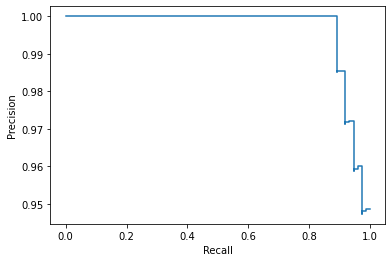

In [161]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
precision, recall, _ = precision_recall_curve(preds["true"], preds["pred"])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


(114, 30)


<AxesSubplot:>

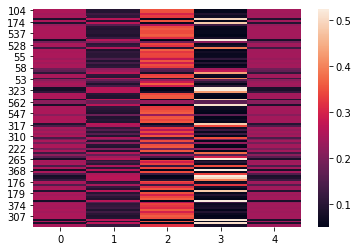

In [162]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = pd.DataFrame(state_mapping(X_ts.values).numpy(), index=X_ts.index)
sns.heatmap(pred_emb)

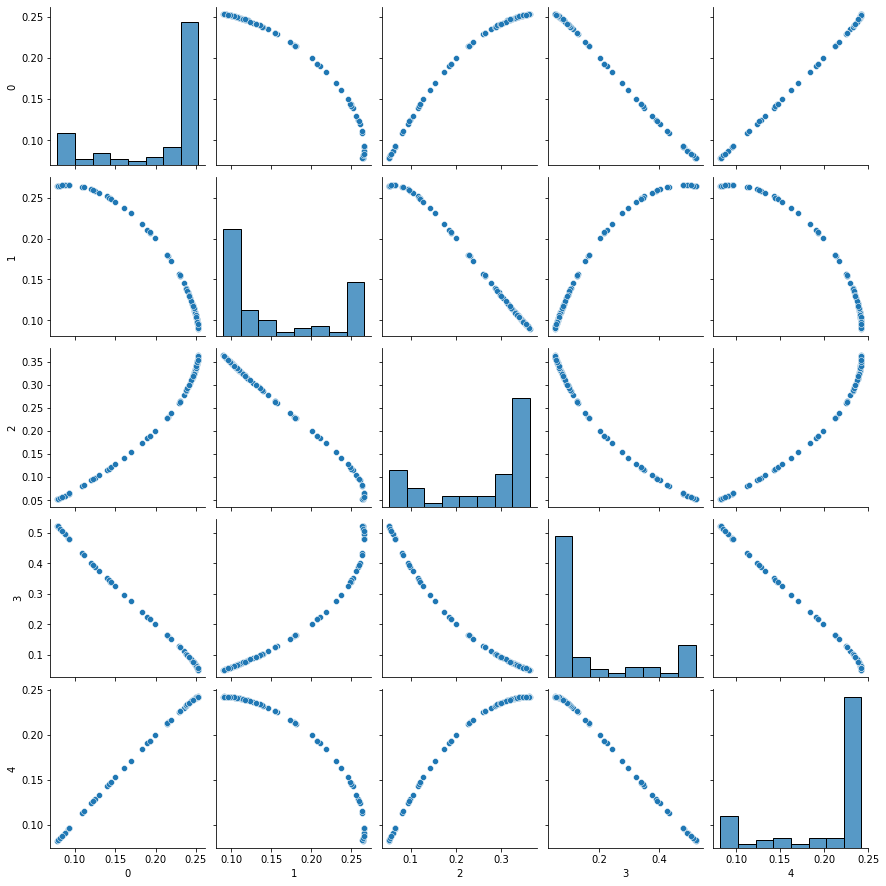

In [163]:
sns.pairplot(pred_emb)

In [164]:
X_state = utils.agg_data_by_state(X_ts, pred_emb)
X_state

,0,1,2,3,4
mean radius,12.975444,15.095140,12.558330,16.536490,13.035560
mean texture,18.077525,19.419843,17.800972,20.282205,18.116913
mean perimeter,83.826916,98.296529,80.985193,108.160844,84.236702
mean area,542.281806,744.166048,504.088310,886.159491,547.851678
mean smoothness,0.095004,0.096851,0.094773,0.098563,0.095043
mean compactness,0.088902,0.106524,0.085586,0.119146,0.089386
mean concavity,0.063063,0.097395,0.056638,0.121926,0.064003
mean concave points,0.035661,0.056038,0.031947,0.070839,0.036209
mean symmetry,0.179896,0.183343,0.179371,0.186212,0.179978
mean fractal dimension,0.063090,0.061735,0.063440,0.061065,0.063044


In [165]:
mod.layers[-1].state_conditional_means.numpy()

array([[0.6869774 ],
       [0.470143  ],
       [0.7609147 ],
       [0.34465903],
       [0.6787518 ]], dtype=float32)

In [166]:
utils.size_state(pred_emb)

state
0    23.772362
1    17.590101
2    29.457136
3    19.958662
4    23.221739
dtype: float32

In [167]:
X_state

state,0,1,2,3,4
mean radius,12.975444,15.095140,12.558330,16.536490,13.035560
mean texture,18.077525,19.419843,17.800972,20.282205,18.116913
mean perimeter,83.826916,98.296529,80.985193,108.160844,84.236702
mean area,542.281806,744.166048,504.088310,886.159491,547.851678
mean smoothness,0.095004,0.096851,0.094773,0.098563,0.095043
mean compactness,0.088902,0.106524,0.085586,0.119146,0.089386
mean concavity,0.063063,0.097395,0.056638,0.121926,0.064003
mean concave points,0.035661,0.056038,0.031947,0.070839,0.036209
mean symmetry,0.179896,0.183343,0.179371,0.186212,0.179978
mean fractal dimension,0.063090,0.061735,0.063440,0.061065,0.063044


<AxesSubplot:>

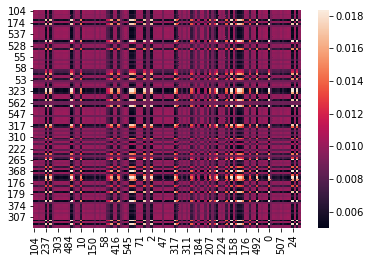

In [168]:
sns.heatmap(pred_emb.dot(utils.col_normalize(pred_emb).transpose()))

## Explain predictions

In [182]:
pred_fn = lambda x: mod.predict(x)[:, 0]

In [187]:
import shap
# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(pred_fn, X_ts)
explainer.feature_names

In [191]:
shap_values = explainer(X_ts.iloc[:20])  # ~20sec

Permutation explainer: 21it [00:35,  1.68s/it]                        


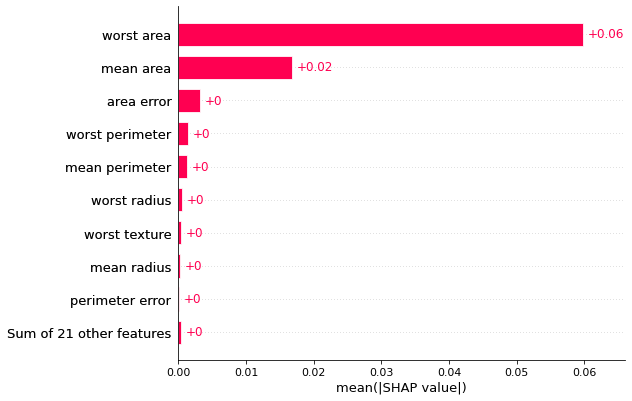

In [193]:
shap.plots.bar(shap_values)

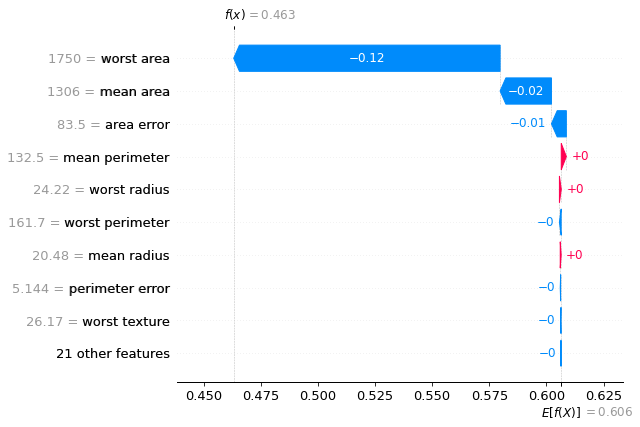

In [199]:
shap.plots.waterfall(shap_values[5])

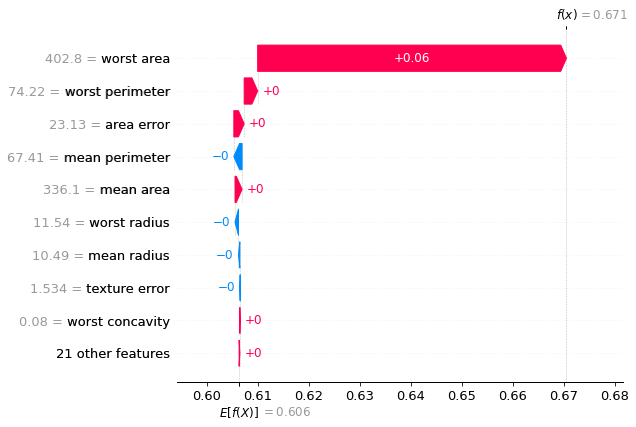

In [200]:
shap.plots.waterfall(shap_values[0])

# Example of single `PRESS()` layer

In [201]:
mod = tf.keras.Sequential()
mod.add(layers.PredictiveStateSimplex(n_states=6, activity_regularizer=regularizers.Uniform(0.01), input_dim=X.shape[1]))
mod.add(layers.PredictiveStateMeans(units=1, activation="sigmoid"))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=metrics)
mod.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictive_state_simplex_18  (None, 6)                186       
  (PredictiveStateSimplex)                                       
                                                                 
 predictive_state_means_18 (  (None, 1)                6         
 PredictiveStateMeans)                                           
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [202]:
mod.fit(X_tr, y_tr, epochs=2)

Epoch 1/2
15/15 [==============================] - 1s 1ms/step - loss: 0.7579 - aupr: 0.6999 - auc_roc: 0.5035
Epoch 2/2
15/15 [==============================] - 0s 1ms/step - loss: 0.7322 - aupr: 0.6061 - auc_roc: 0.4979


In [207]:
mod = tf.keras.Sequential()
mod.add(layers.PRESS(units=1, n_states=6, activation="sigmoid", activity_regularizer=regularizers.Uniform(0.1), input_dim=X.shape[1]))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 press_2 (PRESS)             (None, 1)                 192       
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [208]:
mod.fit(X_tr, y_tr, epochs=12)

Epoch 1/12
15/15 [==============================] - 1s 1ms/step - loss: 0.6257 - aupr: 0.9132 - auc_roc: 0.8765
Epoch 2/12
15/15 [==============================] - 0s 1ms/step - loss: 0.5546 - aupr: 0.8193 - auc_roc: 0.8432
Epoch 3/12
15/15 [==============================] - 0s 1ms/step - loss: 0.5144 - aupr: 0.9108 - auc_roc: 0.8898
Epoch 4/12
15/15 [==============================] - 0s 1ms/step - loss: 0.4873 - aupr: 0.9050 - auc_roc: 0.9066
Epoch 5/12
15/15 [==============================] - 0s 1ms/step - loss: 0.4649 - aupr: 0.9568 - auc_roc: 0.9406
Epoch 6/12
15/15 [==============================] - 0s 2ms/step - loss: 0.4583 - aupr: 0.9229 - auc_roc: 0.9259
Epoch 7/12
15/15 [==============================] - 0s 1ms/step - loss: 0.4448 - aupr: 0.9542 - auc_roc: 0.9477
Epoch 8/12
15/15 [==============================] - 0s 1ms/step - loss: 0.4489 - aupr: 0.9197 - auc_roc: 0.9220
Epoch 9/12
15/15 [==============================] - 0s 1ms/step - loss: 0.4410 - aupr: 0.9255 - auc_roc: